# PDE megoldó FiPy csomaggal


A következő package-ek szükségesek:
- future
- fipy
- numpy
- matplotlib
- scipy

A megoldandó differenciálegyenlet általános alakja:

$$ \frac{\partial n(r,t)}{\partial t}=D\frac{\partial^2 n(r,t)}{\partial r^2}-K\frac{\partial n(r,t)}{\partial r}+S(r,t) $$

### Importálások és saját függvények

A Dirac-delta függvény visszaadja a következőt: ahol
$$ x<\varepsilon\quad\text{és}\quad x>-\varepsilon \text{,}$$
ott:
$$ \frac{1+\cos(\frac{\pi x}{\varepsilon})\cdot\varepsilon}{2} $$

In [73]:
import fipy as fp
from fipy.tools import numerix  # FiPy-al használatos, gyakorlatilag numpy
import copy
import matplotlib

#Dirac delta függvény numerikus implementálása
def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon))) / 2 / epsilon

Text(0, 0.5, 'idő (s)')

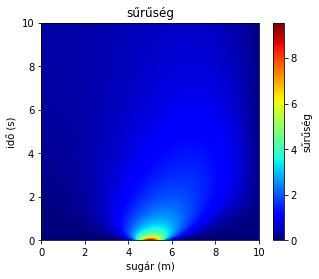

In [94]:
# Dirac delta a kezdeti feltételben, diffúzió és konvekció
# Bal oldalt 0. Neumann határfeltétel, jobb oldalt 0. Dirichlet határfeltétel
# Sugár felénél Dirac-delta kezdeti feltétel
# Újrainicializáláshoz a TEMPLATE alatti részt kell másolni

## TEMPLATE ##

R = 10.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracCoeff = 10.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = 1.  ## diffúziós együttható
convCoeff = [0.5,]  ## konvekciós együttható
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
n.setValue(delta_func(mesh.x - diracLoc, 100 * dr, diracCoeff))  ## Dirac-delta kezdeti feltétel
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ## ábrázolás
viewer.axes.set_xlabel("sugár (m)")  ## tengelyfeliratok megadási módja (nem dokumentált)
viewer.axes.set_ylabel("idő (s)")

Text(0, 0.5, 'idő (s)')

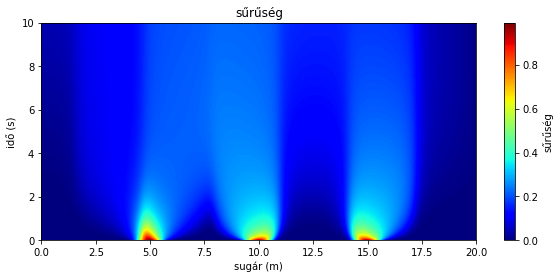

In [95]:
## Sugár mentén változó diffúziós együttható és több Dirac-delta kezdeti feltétel, zérus konvekció
## Érdemes megfigyelni a Dirac-delták viselkedését és a diffúziós együttható helyfüggését változtatni

R = 20.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracLoc2 = R / 4.
diracLoc3 = 15.
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = numerix.cos(mesh.x) ** 2 + 0.1  ## diffúziós együttható <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
convCoeff = [0.,]  ## konvekciós együttható
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
value1 = copy.deepcopy(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff))
n.setValue(value1)  ## Dirac-delta kezdeti feltétel
n.setValue(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc3, 50 * dr, diracCoeff))  ## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == + fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás
viewer.axes.set_xlabel("sugár (m)")
viewer.axes.set_ylabel("idő (s)")

Negatív diffúziós együtthatóra nem működik a fenti szimuláció.

Konvekciós együttható helyfüggését a következő cellában láthatjuk:

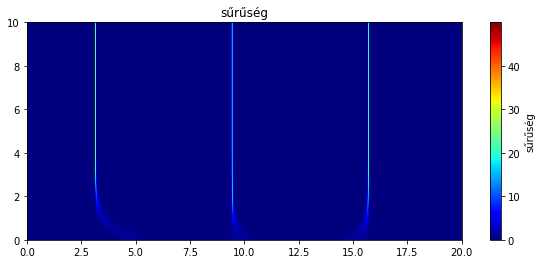

In [102]:
## Sugár mentén változó konvekciós együttható és több Dirac-delta kezdeti feltétel, zérus konvekció
## Érdemes kipróbálni a 0 diffúzió esetet úgy, hogy a konvekciós együttható van ahol 0.

R = 20.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracLoc2 = R / 4.
diracLoc3 = 15.
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = 0.  ## diffúziós együttható 
cC = (numerix.sin(mesh.x)) * 2  ## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])  ## konvekciós együttható
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
value1 = copy.deepcopy(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff))
n.setValue(value1)  ## Dirac-delta kezdeti feltétel
n.setValue(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc3, 50 * dr, diracCoeff))
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == + fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás

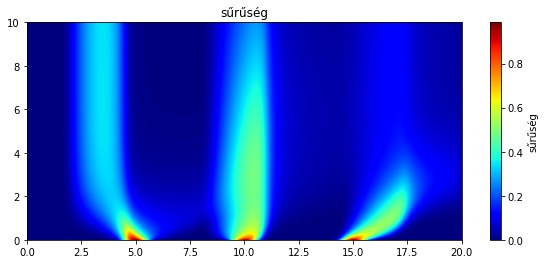

In [107]:
## Sugár mentén változó diffúziós ÉS konvekciós együttható, több Dirac-delta kezdeti feltétel

R = 20.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracLoc2 = R / 4.
diracLoc3 = 15.
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = numerix.cos(mesh.x) ** 2 + 0.1  ## diffúziós együttható <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
cC = (numerix.sin(mesh.x) + (mesh.x / 10))
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])  ## konvekciós együttható <<<<<<<<<<<<<<<<<<<<<<<
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
value1 = copy.deepcopy(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff))
n.setValue(value1)  ## Dirac-delta kezdeti feltétel
n.setValue(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc3, 50 * dr, diracCoeff))
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == + fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás

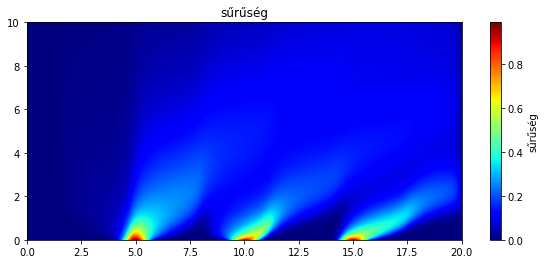

In [111]:
## Előző példa forrással és monoton növő konvekciós együtthatóval

R = 20.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracLoc2 = R / 4.
diracLoc3 = 15.
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = numerix.cos(mesh.x) ** 2 + 0.1  ## diffúziós együttható <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
cC = (mesh.x / 10)
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])  ## konvekciós együttható <<<<<<<<<<<<<<<<<<<<<<<
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
value1 = copy.deepcopy(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff))
n.setValue(value1)  ## Dirac-delta kezdeti feltétel
n.setValue(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc3, 50 * dr, diracCoeff))
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == + fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás

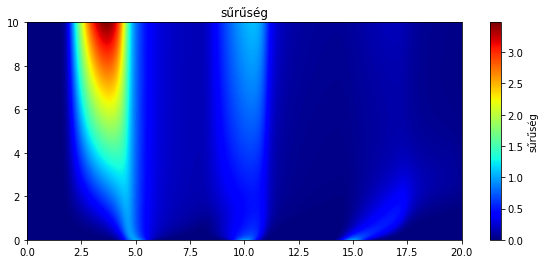

In [109]:
## Előző példa Dirac-delta forrással

R = 20.  ## teljes sugár
nr = 1000  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 10.  ## teljes szimulációs időtartam
nt = 1000  ## időosztások száma
dt = duration / nt  ## időlépés

## 2D mesh és CellVariable az idő- és térfüggő eredmények tárolásához
mesh2D = fp.Grid2D(dx=dr, dy=dt, nx=nr, ny=nt)
cellvar2D = fp.CellVariable(mesh = mesh2D, name="sűrűség", unit="1/m**3")

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén
diracLoc = R / 2. ## Dirac-delta helyzete
diracLoc2 = R / 4.
diracLoc3 = 15.
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)
diffCoeff = numerix.cos(mesh.x) ** 2 + 0.1  ## diffúziós együttható <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
cC = (numerix.sin(mesh.x) + (mesh.x / 10))
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])  ## konvekciós együttható <<<<<<<<<<<<<<<<<<<<<<<
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
value1 = copy.deepcopy(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff))
n.setValue(value1)  ## Dirac-delta kezdeti feltétel
n.setValue(delta_func(mesh.x - diracLoc, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff)
           + delta_func(mesh.x - diracLoc3, 50 * dr, diracCoeff))
n.setValue(0, where=mesh.x < 2 * dr)  ## A tartomány szélére eső Dirac-delta esetén szükségesek...
n.setValue(0, where=mesh.x > R - (2 * dr))  ## ... de csak sima konvekciónál fontos

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == + fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff) 
      + delta_func(mesh.x - diracLoc2, 50 * dr, diracCoeff))  ## forrás <<<<<<<<<<<<<<<<<<<<<<<<<<<<

## Tér- és időfüggő adatbetöltés a 2D változóba
for tcut in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    cellvar2D[tcut*nr:(tcut*nr)+nr]=copy.deepcopy(n.value)
viewer = fp.Viewer(vars=cellvar2D)  ##ábrázolás